# Logistic Regression and Resampling Methods
By Adrian Chavez-Loya

## Background

The longevity of an athlete's career is critically important both for the individual and for the team looking to employ their efforts. Ideally, using statistics from their first season, you'd be able to determine the likelihood they'll be a solid long term investment. This dataset seeks to explore that relationship by providing first season statistics for a number of NBA players, as well as a response variable of whether they lasted in the league for 5 years or more. Our task is to use the skills we've learned in Logistic Regression to construct a model that can model this.

### Relevant Dataset

`nba_logreg.csv`

Source: https://data.world/exercises/logistic-regression-exercise-1

## Task 1: Form a training and testing dataset to be used for this analysis.
Note: Remember that we shouldn't touch the testing dataset until we're completely done with our model to ensure it's an accurate representation of the generalizability.

In [140]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split as sklearn_train_test_split
nba_data = pd.read_csv('nba_logreg.csv') #nba data set imported
nba_data.dropna(inplace=True)

def train_test_split(df, test_size=0.2, random_state=1):
    X = df[['FG%', 'GP']]  
    y = df['TARGET_5Yrs'] 

    # used sklearn train_test_split for simplicity!
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(nba_data)#train-test split

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)



Training data shape: (1063, 2)
Testing data shape: (266, 2)


## Task 2: Using 10-fold Cross-Validation, identify the best threshold for predicting 1 or 0 for your logistic regression model that predicts whether they will last 5 years or not given their FG% and Games Played (GP).
The easiest way to do this would probably be a double for-loop, where the outer loop iterates over a list of possible threshold values and the inner loop is your 10-fold CV. You can then plot the thresholds vs the average accuracy for each threshold.

In [146]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def logistic_regression_cv(data, threshold_list):
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    accuracies = []

    for threshold in threshold_list:
        fold_accuracies = []
        for train_index, val_index in kf.split(data):
            train_fold = data.iloc[train_index]
            val_fold = data.iloc[val_index]

            formula = 'TARGET_5Yrs ~ Q("FG%") + GP'  

            try:
                
                logit_model = smf.logit(formula=formula, data=train_fold).fit(disp=0)
                X_val = val_fold[['FG%', 'GP']]
                y_val = val_fold['TARGET_5Yrs']
                preds = (logit_model.predict(X_val) >= threshold).astype(int)
                accuracy = accuracy_score(y_val, preds)
                fold_accuracies.append(accuracy)
            except Exception as e:
                print(f"Error in fold: {e}")
                continue

        avg_accuracy = np.mean(fold_accuracies) # avg accuracy
        accuracies.append(avg_accuracy)

    best_index = np.argmax(accuracies)
    best_threshold = threshold_list[best_index]
    best_accuracy = accuracies[best_index]

    return best_threshold, best_accuracy

threshold_list = np.linspace(0.1, 0.9, 9)
t_threshold, best_accuracy = logistic_regression_cv(nba_data, threshold_list)

print("Best threshold found:", best_threshold)
print("Corresponding average accuracy:", best_accuracy)

#Best threshold found shown below: 

Best threshold found: 0.6
Corresponding average accuracy: 0.6960298473456368


## Task 3: Using n-fold CV, estimate the accuracy of your chosen threshold on unseen data.
This should be very similar to the previous task except your using the best threshold from the previous task and doing n-fold CV to get an estimate of the accuracy on unseen data (since each observation will be predicted on when it is not in the training fold).

In [150]:
formula = 'TARGET_5Yrs ~ Q("FG%") + GP'
final_logit_model = smf.logit(formula=formula, data=train_data).fit()

print(final_logit_model.summary())

X_test = test_data[['FG%', 'GP']]
y_test = test_data['TARGET_5Yrs']
test_data['predicted_prob'] = final_logit_model.predict(X_test) #probabality prediction

best_threshold = 0.6
test_data['predicted_class'] = (test_data['predicted_prob'] >= best_threshold).astype(int)

accuracy = np.mean(test_data['predicted_class'] == y_test)#accuracy test
print(f"Accuracy on test set: {accuracy:.4f}")


Optimization terminated successfully.
         Current function value: 0.568003
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            TARGET_5Yrs   No. Observations:                 1072
Model:                          Logit   Df Residuals:                     1069
Method:                           MLE   Df Model:                            2
Date:                Fri, 14 Jun 2024   Pseudo R-squ.:                  0.1444
Time:                        22:48:48   Log-Likelihood:                -608.90
converged:                       True   LL-Null:                       -711.70
Covariance Type:            nonrobust   LLR p-value:                 2.259e-45
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5464      0.550     -8.266      0.000      -5.624      -3.468
Q("FG%")       0.0471      0.

## Task 4: Using the bootstrap, get the mean and standard error of each coefficient for your logistic regression model.
Remember that the bootstrap just involves taking repeated samples from your original dataset up to the size of that dataset but with replacement. The number of samples you draw is your choice but somewhere around 11 is a fine number.

In [126]:

formula = 'TARGET_5Yrs ~ Q("FG%") + GP'
logit_model = smf.logit(formula=formula, data=train_data).fit()
n_bootstrap = 11 #used BS sample of 11

def bootstrap_logit(data, formula, n_bootstrap):
    n_obs = data.shape[0]
    coefficients = []

    for _ in range(n_bootstrap):
        bootstrap_sample = resample(data, replace=True, n_samples=n_obs, random_state=_)
        model = smf.logit(formula=formula, data=bootstrap_sample).fit(disp=0) 
        coef = model.params
        coefficients.append(coef)
        coefficients_df = pd.DataFrame(coefficients)
    
    coef_mean = coefficients_df.mean()
    coef_se = coefficients_df.sem()  #mean and SE
    return coef_mean, coef_se

coef_mean, coef_se = bootstrap_logit(train_data, formula, n_bootstrap)

print("Mean of Coefficients:")  # print results
print(coef_mean)
print("\nStandard Error (SE) of Coefficients:")
print(coef_se)

Optimization terminated successfully.
         Current function value: 0.568003
         Iterations 5
Mean of Coefficients:
Intercept   -4.672425
Q("FG%")     0.046522
GP           0.052069
dtype: float64

Standard Error (SE) of Coefficients:
Intercept    0.163395
Q("FG%")     0.003977
GP           0.001084
dtype: float64


## Task 5: Use your bootstrap estimates of your coefficients to predict the probability of lasting 5 years or not for your test data. If you use the threshold from before, what accuracy do you get? Is this similar to what you saw from n-fold CV?
Note: Look back at the Logistic Regression slides to see how to calculate probability.

Accuracy using bootstrap mean coefficients: 0.6306
Cross-validation accuracy: 0.6960 (previously obtained)


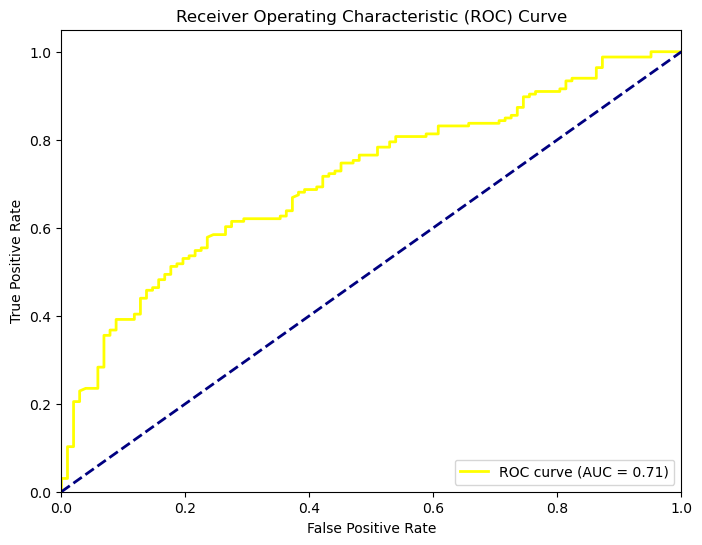

In [138]:
coef_mean = {
    'Intercept': -4.672425, # results from before
    'Q("FG%")': 0.046522,
    'GP': 0.052069
}

def logistic_regression_prob(X, coefficients):
    lin_pred = coefficients['Intercept'] + \
               coefficients['Q("FG%")'] * X['FG%'] + \
               coefficients['GP'] * X['GP']
    prob = 1 / (1 + np.exp(-lin_pred)) #prob. prediction
    
    return prob

test_data['predicted_prob'] = logistic_regression_prob(test_data, coef_mean)

test_data['predicted_class'] = (test_data['predicted_prob'] >= 0.6).astype(int) # .6 threshold

accuracy_bootstrap = accuracy_score(y_test, test_data['predicted_class']) #accuracy calc

print(f"Accuracy using bootstrap mean coefficients: {accuracy_bootstrap:.4f}")
print(f"Cross-validation accuracy: {best_accuracy:.4f} (previously obtained)") #cross valid.


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, test_data['predicted_prob'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='yellow', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
# ROC Curve and AUC plot print below